收集数据
  处理数据: QQQ
  处理数据: PSQ
数据收集完成，共有 4157 个交易日

正在导出日线数据到Excel
已将 QQQ 的日线数据保存到: backtest_output3\QQQ_daily_data.xlsx
已将 PSQ 的日线数据保存到: backtest_output3\PSQ_daily_data.xlsx

正在回测...

多空策略统计:
  - 持有QQQ天数: 2769 (66.6%)
  - 持有PSQ天数: 1388 (33.4%)
  - 总交易次数: 450


策略性能对比
      策略  年化收益_日历年(%)  年化收益_交易日(%)  年化波动(%)  夏普比率  卡玛比率  最大回撤(%)        最终资产  总收益率(%)  总交易日  日历年数  QQQ持仓天数  PSQ持仓天数  QQQ持仓占比(%)
QQQ_长期持有        19.07        19.11    21.10  0.90  0.54    35.62 17906986.78  1690.70  4157 16.53     4157        0       100.0
QQQ_多空策略        -3.20        -3.21    21.28 -0.15 -0.05    65.54   583925.55   -41.61  4157 16.53     2769     1388        66.6

策略对比结果已保存到: backtest_output3\strategy_comparison.xlsx

详细回测结果已保存到: backtest_output3\detailed_backtest_results.xlsx


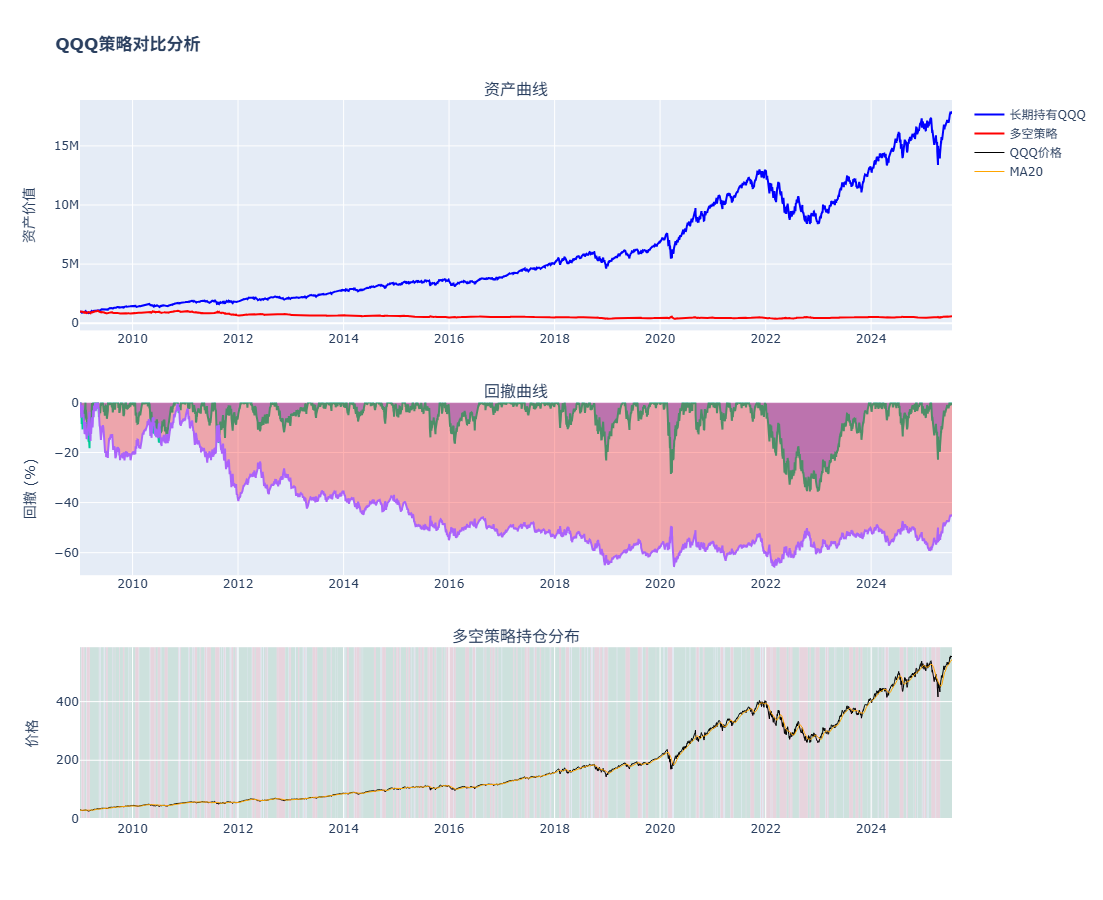


回测完成！所有结果已保存到: backtest_output3


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')

# 1.全局配置 
Parameter = {
    'long_ticker': 'QQQ',            # 做多标的
    'short_ticker': 'PSQ',           # 做空标的 (ProShares Short QQQ - 1倍反向ETF)
    'start_date': '2009-01-01',      # 开始日期
    'end_date': '2025-07-14',        # 结束日期 (包含当天)
    'cash': 1000000,                 # 初始资金
    'fee': 0.001,                    # 交易手续费
    'ma_period': 20,                 # 均线周期
    'output_dir': 'backtest_output3'  # 结果放的文件夹
}


# 2.功能函数 
def get_data(long_ticker, short_ticker, start, end, ma_period):
    """获取QQQ和PSQ的数据"""
    print("收集数据")
    
    start_dt = pd.to_datetime(start) - timedelta(days=ma_period*2)
    end_dt = pd.to_datetime(end) + timedelta(days=1)
    
    print(f"  处理数据: {long_ticker}")
    qqq_data = yf.Ticker(long_ticker).history(
        start=start_dt.strftime('%Y-%m-%d'),
        end=end_dt.strftime('%Y-%m-%d'),
        auto_adjust=False
    )
    
    if qqq_data.empty:
        raise ValueError(f"{long_ticker} 数据获取失败")
    
    print(f"  处理数据: {short_ticker}")
    psq_data = yf.Ticker(short_ticker).history(
        start=start_dt.strftime('%Y-%m-%d'),
        end=end_dt.strftime('%Y-%m-%d'),
        auto_adjust=False
    )
    
    if psq_data.empty:
        raise ValueError(f"{short_ticker} 数据获取失败")
    
    qqq_data.index = qqq_data.index.tz_localize(None)
    qqq_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 
                            'Close': 'close', 'Volume': 'volume'}, inplace=True)
    qqq_data[f'ma{ma_period}'] = qqq_data['close'].rolling(ma_period).mean()
    qqq_data['return'] = qqq_data['close'].pct_change()
    
    psq_data.index = psq_data.index.tz_localize(None)
    psq_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 
                            'Close': 'close', 'Volume': 'volume'}, inplace=True)
    psq_data['return'] = psq_data['close'].pct_change()
    
    qqq_final = qqq_data[qqq_data.index >= pd.to_datetime(start)].dropna().copy()
    psq_final = psq_data[psq_data.index >= pd.to_datetime(start)].dropna().copy()
    
    common_dates = qqq_final.index.intersection(psq_final.index)
    qqq_final = qqq_final.loc[common_dates]
    psq_final = psq_final.loc[common_dates]
    
    print(f"数据收集完成，共有 {len(common_dates)} 个交易日")
    return qqq_final, psq_final

def save_data_to_excel(qqq_df, psq_df, output_dir):
    """导出数据到Excel"""
    print("\n正在导出日线数据到Excel")
    
    output_path = os.path.join(output_dir, f"QQQ_daily_data.xlsx")
    export_df = qqq_df.copy()
    export_df['turnover'] = export_df['close'] * export_df['volume']
    export_df.reset_index(inplace=True)
    export_df.rename(columns={'Date': 'date'}, inplace=True)
    export_df['date'] = export_df['date'].dt.strftime('%Y-%m-%d')
    final_df = export_df[['date', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'ma20']]
    final_df.to_excel(output_path, index=False)
    print(f"已将 QQQ 的日线数据保存到: {output_path}")
    
    output_path = os.path.join(output_dir, f"PSQ_daily_data.xlsx")
    export_df = psq_df.copy()
    export_df['turnover'] = export_df['close'] * export_df['volume']
    export_df.reset_index(inplace=True)
    export_df.rename(columns={'Date': 'date'}, inplace=True)
    export_df['date'] = export_df['date'].dt.strftime('%Y-%m-%d')
    final_df = export_df[['date', 'open', 'high', 'low', 'close', 'volume', 'turnover']]
    final_df.to_excel(output_path, index=False)
    print(f"已将 PSQ 的日线数据保存到: {output_path}")

def run_buy_and_hold(qqq_df, cash, fee):
    """策略1：长期持有QQQ"""
    df_res = qqq_df.copy()
    df_res['equity'] = 0.0
    df_res['position'] = 'QQQ'  # 始终持有QQQ
    
    # 第一天买入，扣除手续费
    fee_amount = cash * fee 
    df_res.iloc[0, df_res.columns.get_loc('equity')] = cash - fee_amount
    
    # 计算每日权益
    for i in range(1, len(df_res)):
        prev_equity = df_res.iloc[i-1]['equity']
        row = df_res.iloc[i]
        df_res.iloc[i, df_res.columns.get_loc('equity')] = prev_equity * (1 + row['return'])
    
    df_res['strategy_return'] = df_res['equity'].pct_change().fillna(0)
    return df_res

def run_long_short_strategy(qqq_df, psq_df, cash, fee, ma_period):
    """策略2：多空策略
    - QQQ收盘价 > MA20：持有QQQ（做多）
    - QQQ收盘价 <= MA20：持有PSQ（做空QQQ）
    """
    df_res = qqq_df.copy()
    df_res['psq_return'] = psq_df['return']
    
    # 1 = 持有QQQ，0 = 持有PSQ
    df_res['signal'] = np.where(df_res['close'] > df_res[f'ma{ma_period}'], 1, 0)
    df_res['trade_signal'] = df_res['signal'].diff()
    
    df_res['equity'] = 0.0
    df_res['position'] = ''
    df_res['daily_return'] = 0.0
    
    initial_signal = df_res.iloc[0]['signal']
    if initial_signal == 1:
        df_res.iloc[0, df_res.columns.get_loc('position')] = 'QQQ'
        df_res.iloc[0, df_res.columns.get_loc('equity')] = cash - cash * fee
    else:
        df_res.iloc[0, df_res.columns.get_loc('position')] = 'PSQ'
        df_res.iloc[0, df_res.columns.get_loc('equity')] = cash - cash * fee
    
    for i in range(1, len(df_res)):
        row = df_res.iloc[i]
        prev_row = df_res.iloc[i-1]
        
        prev_signal = prev_row['signal']
        prev_equity = prev_row['equity']
        
        if prev_signal == 1:  # 昨天持有QQQ
            daily_return = row['return']  # 使用QQQ的收益率
            df_res.iloc[i, df_res.columns.get_loc('position')] = 'QQQ'
        else:  # 昨天持有PSQ
            daily_return = row['psq_return']  # 使用PSQ的收益率
            df_res.iloc[i, df_res.columns.get_loc('position')] = 'PSQ'
        
        df_res.iloc[i, df_res.columns.get_loc('daily_return')] = daily_return
        
        current_equity = prev_equity * (1 + daily_return)
        
        if row['trade_signal'] != 0 and not np.isnan(row['trade_signal']):
            fee_amount = current_equity * fee
            current_equity = current_equity - fee_amount
            
            if row['signal'] == 1:
                df_res.iloc[i, df_res.columns.get_loc('position')] = 'QQQ'
            else:
                df_res.iloc[i, df_res.columns.get_loc('position')] = 'PSQ'
        
        df_res.iloc[i, df_res.columns.get_loc('equity')] = current_equity
    
    df_res['strategy_return'] = df_res['equity'].pct_change().fillna(0)
    
    qqq_days = (df_res['position'] == 'QQQ').sum()
    psq_days = (df_res['position'] == 'PSQ').sum()
    total_trades = abs(df_res['trade_signal']).sum()
    
    print(f"\n多空策略统计:")
    print(f"  - 持有QQQ天数: {qqq_days} ({100*qqq_days/len(df_res):.1f}%)")
    print(f"  - 持有PSQ天数: {psq_days} ({100*psq_days/len(df_res):.1f}%)")
    print(f"  - 总交易次数: {int(total_trades)}")
    
    return df_res

def calc_stats(df_res, cash, strategy_name):
    """计算策略统计指标"""
    equity = df_res['equity']
    returns = df_res['strategy_return']
    if len(equity) < 2: return {}
    
    calendar_years = (equity.index[-1] - equity.index[0]).days / 365.25
    trading_days = len(equity)
    trading_years = trading_days / 252
    
    final_equity = equity.iloc[-1]
    total_return_ratio = final_equity / cash
    
    annual_ret_calendar = 100 * ((total_return_ratio)**(1/calendar_years) - 1) if calendar_years > 0 else 0
    annual_ret_trading = 100 * ((total_return_ratio)**(1/trading_years) - 1) if trading_years > 0 else 0
    
    annual_vol = returns.std() * np.sqrt(252) * 100
    
    sharpe = annual_ret_calendar / annual_vol if annual_vol > 0 else 0
    
    running_max = equity.expanding().max()
    drawdown = (equity - running_max) / running_max
    max_dd = -100 * drawdown.min()
    
    calmar = annual_ret_calendar / max_dd if max_dd > 0 else 0
    
    stats = {
        '策略': strategy_name,
        '年化收益_日历年(%)': round(annual_ret_calendar, 2),
        '年化收益_交易日(%)': round(annual_ret_trading, 2),
        '年化波动(%)': round(annual_vol, 2),
        '夏普比率': round(sharpe, 2),
        '卡玛比率': round(calmar, 2),
        '最大回撤(%)': round(max_dd, 2),
        '最终资产': round(final_equity, 2),
        '总收益率(%)': round((total_return_ratio - 1) * 100, 2),
        '总交易日': int(trading_days),
        '日历年数': round(calendar_years, 2)
    }
    
    if 'position' in df_res.columns:
        qqq_days = (df_res['position'] == 'QQQ').sum()
        psq_days = (df_res['position'] == 'PSQ').sum()
        stats['QQQ持仓天数'] = qqq_days
        stats['PSQ持仓天数'] = psq_days
        stats['QQQ持仓占比(%)'] = round(100 * qqq_days / len(df_res), 1)
    
    return stats

def make_plot(df_bh, df_ls, ma_period):
    """绘制对比图表"""
    fig = make_subplots(
        rows=3, cols=1, 
        subplot_titles=('资产曲线', '回撤曲线', '多空策略持仓分布'),
        row_heights=[0.4, 0.3, 0.3],
        vertical_spacing=0.1
    )
    
    fig.add_trace(
        go.Scatter(x=df_bh.index, y=df_bh['equity'], name='长期持有QQQ', line=dict(color='blue')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=df_ls.index, y=df_ls['equity'], name='多空策略', line=dict(color='red')),
        row=1, col=1
    )
    
    dd_bh = 100 * (df_bh['equity'] - df_bh['equity'].expanding().max()) / df_bh['equity'].expanding().max()
    dd_ls = 100 * (df_ls['equity'] - df_ls['equity'].expanding().max()) / df_ls['equity'].expanding().max()
    
    fig.add_trace(
        go.Scatter(x=df_bh.index, y=dd_bh, fill='tozeroy', name='长期持有回撤', 
                  showlegend=False, fillcolor='rgba(0,0,255,0.3)'),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=df_ls.index, y=dd_ls, fill='tozeroy', name='多空策略回撤', 
                  showlegend=False, fillcolor='rgba(255,0,0,0.3)'),
        row=2, col=1
    )
    
    # 3. 多空策略持仓分布
    fig.add_trace(
        go.Scatter(x=df_ls.index, y=df_ls['close'], name='QQQ价格', 
                  line=dict(color='black', width=1)),
        row=3, col=1
    )
    fig.add_trace(
        go.Scatter(x=df_ls.index, y=df_ls[f'ma{ma_period}'], name=f'MA{ma_period}', 
                  line=dict(color='orange', width=1)),
        row=3, col=1
    )
    
    for i in range(len(df_ls)):
        if i == 0 or df_ls.iloc[i]['position'] != df_ls.iloc[i-1]['position']:
            # 找到连续相同持仓的结束位置
            j = i + 1
            while j < len(df_ls) and df_ls.iloc[j]['position'] == df_ls.iloc[i]['position']:
                j += 1
            
            # 根据持仓类型设置背景色
            if df_ls.iloc[i]['position'] == 'QQQ':
                fig.add_vrect(
                    x0=df_ls.index[i], x1=df_ls.index[min(j-1, len(df_ls)-1)],
                    fillcolor="green", opacity=0.1,
                    layer="below", line_width=0,
                    row=3, col=1
                )
            else:  # PSQ
                fig.add_vrect(
                    x0=df_ls.index[i], x1=df_ls.index[min(j-1, len(df_ls)-1)],
                    fillcolor="red", opacity=0.1,
                    layer="below", line_width=0,
                    row=3, col=1
                )
    
    fig.update_layout(
        title_text='<b>QQQ策略对比分析</b>',
        height=900,
        showlegend=True,
        hovermode='x unified'
    )
    
    fig.update_yaxes(title_text="资产价值", row=1, col=1)
    fig.update_yaxes(title_text="回撤 (%)", row=2, col=1)
    fig.update_yaxes(title_text="价格", row=3, col=1)
    
    fig.show()

def export_detailed_results(df_bh, df_ls, output_dir):
    """导出详细的回测结果"""
    output_path = os.path.join(output_dir, 'detailed_backtest_results.xlsx')
    
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # 导出长期持有策略结果
        bh_export = df_bh[['close', 'ma20', 'return', 'equity', 'strategy_return']].copy()
        bh_export.index.name = 'date'
        bh_export.to_excel(writer, sheet_name='长期持有策略')
        
        # 导出多空策略结果
        ls_export = df_ls[['close', 'ma20', 'signal', 'position', 'daily_return', 
                          'equity', 'strategy_return', 'trade_signal']].copy()
        ls_export.index.name = 'date'
        ls_export.to_excel(writer, sheet_name='多空策略')
        
    print(f"\n详细回测结果已保存到: {output_path}")


# 3.主流程 

def main():
    if not os.path.exists(Parameter['output_dir']):
        os.makedirs(Parameter['output_dir'])
    
    try:
        qqq_data, psq_data = get_data(
            Parameter['long_ticker'], 
            Parameter['short_ticker'],
            Parameter['start_date'], 
            Parameter['end_date'],
            Parameter['ma_period']
        )
        
        save_data_to_excel(qqq_data, psq_data, Parameter['output_dir'])
        
        print(f"\n正在回测...")
        
        # 策略1：长期持有QQQ
        result_bh = run_buy_and_hold(qqq_data, Parameter['cash'], Parameter['fee'])
        stats_bh = calc_stats(result_bh, Parameter['cash'], 'QQQ_长期持有')
        
        # 策略2：多空策略
        result_ls = run_long_short_strategy(
            qqq_data, psq_data, 
            Parameter['cash'], 
            Parameter['fee'],
            Parameter['ma_period']
        )
        stats_ls = calc_stats(result_ls, Parameter['cash'], 'QQQ_多空策略')
        
        print("\n\n" + "="*80)
        print("策略性能对比")
        print("="*80)
        
        stats_df = pd.DataFrame([stats_bh, stats_ls])
        print(stats_df.to_string(index=False))
        
        output_path = os.path.join(Parameter['output_dir'], 'strategy_comparison.xlsx')
        stats_df.to_excel(output_path, index=False)
        print(f"\n策略对比结果已保存到: {output_path}")

        export_detailed_results(result_bh, result_ls, Parameter['output_dir'])
        
        make_plot(result_bh, result_ls, Parameter['ma_period'])
        
        print("\n" + "="*80)
        print("回测完成！所有结果已保存到:", Parameter['output_dir'])
        print("="*80)
        
    except Exception as e:
        print(f"\n错误: {e}")
        import traceback
        traceback.print_exc()


if __name__ == '__main__':
    main()